In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))

tmp.dir <- "/scratch/PI/candes/ukbiobank_tmp"

experiment <- "four"

# Load caviar results
lmm.file <- sprintf("%s/simulations/summary/lmm_%s_locus.txt", tmp.dir, experiment)
Results.lmm <- read_delim(lmm.file, delim=" ", col_types=cols())

# Load knockoffs results
knockoffs.file <- sprintf("%s/simulations/summary/knockoffs_%s_locus.txt", tmp.dir, experiment)
Results.knockoffs <- read_delim(knockoffs.file, delim=" ", col_types=cols())

In [4]:
# Combine results
Results.lmm.tmp <- Results.lmm %>% 
    mutate(Method.type=Method, Method=paste(Method, Clumping, sep="_")) %>% 
    select(-c("Clumping"))
Results.knockoffs.tmp <- Results.knockoffs %>%
    mutate(Method.type=Method, Method=paste(Method, Resolution, sep="_")) %>% 
    select(-c("Resolution"))
Results <- rbind(Results.lmm.tmp, Results.knockoffs.tmp) %>% as_tibble()

Warning message:
“Removed 18 rows containing missing values (geom_errorbar).”Warning message:
“Removed 18 rows containing missing values (geom_errorbar).”

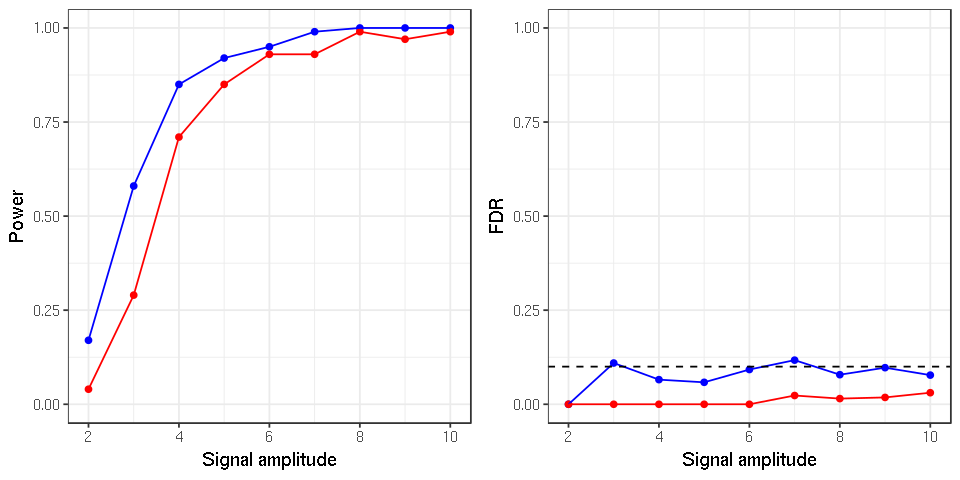

In [6]:
# LMM parameters
threshold <- "5e-08"

Summary <- Results %>% 
    filter(Method %in% c(sprintf("LMM_%s", threshold), "Knockoffs_Radj2")) %>%
    group_by(Method.type, Method, Amplitude) %>%
    summarise(Power.sd=2*sd(Power)/sqrt(n()), Power=mean(Power), 
              FDR.sd=2*sd(FDP)/sqrt(n()), Power=mean(Power), FDR=mean(FDP),
              Size=mean(Size,na.rm=TRUE), BP.width=mean(BP.width,na.rm=TRUE)) %>%
    ungroup() %>%
    select(Method.type, Method, Amplitude, 
           FDR, FDR.sd, Power, Power.sd, Size, BP.width)

options(repr.plot.width=8, repr.plot.height=4)

p.pow <- Summary %>%
    ggplot(aes(x=Amplitude, y=Power, group=Method, color=Method.type, alpha=Method.type)) +
    geom_point() + geom_line() +
    geom_errorbar(width=.1, aes(ymin=Power-Power.sd, 
                                ymax=Power+Power.sd)) +
    scale_colour_manual(values = c("blue", "red")) +
    scale_alpha_manual(values = c(1, 1)) +
    ylim(0,1) +
    xlab("Signal amplitude") + ylab("Power") +
    theme_bw() + guides(colour = guide_legend(ncol = 2)) + theme(legend.position="none")

p.fdp <- Summary %>%
    ggplot(aes(x=Amplitude, y=FDR, group=Method, color=Method.type, alpha=Method.type)) +
    geom_point() + geom_line() +
    geom_errorbar(width=.1, aes(ymin=FDR-FDR.sd, 
                                ymax=FDR+FDR.sd)) +
    geom_hline(yintercept=0.1, linetype=2) +
    scale_colour_manual(values = c("blue", "red")) +
    scale_alpha_manual(values = c(1, 1)) +
    ylim(0,1) +
    xlab("Signal amplitude") + ylab("FDR") +
    theme_bw() + guides(colour = guide_legend(ncol = 2)) + theme(legend.position="none")

pp <- grid.arrange(p.pow, p.fdp, nrow = 1)
p.file <- sprintf("figures/locus_%s.png", threshold)
ggsave(p.file, pp, width=8, height=4)

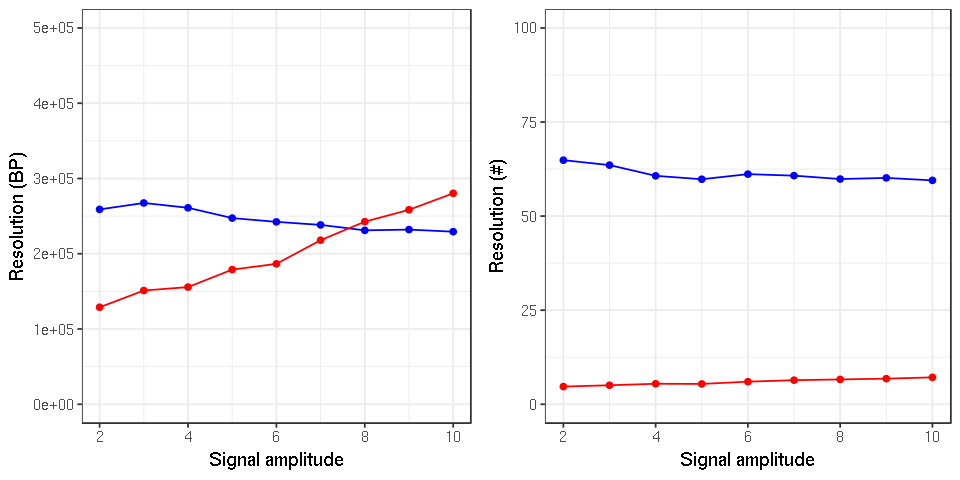

In [89]:
p.BP <- Summary %>%
    ggplot(aes(x=Amplitude, y=BP.width, group=Method, color=Method.type,  alpha=Method.type)) +
    geom_point() + geom_line() +
    scale_colour_manual(values = c("blue", "red")) +
    scale_alpha_manual(values = c(1, 1)) +
    xlab("Signal amplitude") + ylab("Resolution (BP)") +
    ylim(0,500000) +
    theme_bw() + theme(legend.position="none")

p.N <- Summary %>%
    ggplot(aes(x=Amplitude, y=Size, group=Method, color=Method.type, alpha=Method.type)) +
    geom_point() + geom_line() +
    scale_colour_manual(values = c("blue", "red")) +
    scale_alpha_manual(values = c(1, 1)) +
    xlab("Signal amplitude") + ylab("Resolution (#)") +
    ylim(0,100) +
    theme_bw() + theme(legend.position="none")

pp <- grid.arrange(p.BP, p.N, nrow = 1)
p.file <- "figures/locus_resolution_5e-08.png"
ggsave(p.file, pp, width=8, height=4)

## LMM with oracle FDR control

Warning message:
“Removed 18 rows containing missing values (geom_errorbar).”Warning message:
“Removed 18 rows containing missing values (geom_errorbar).”

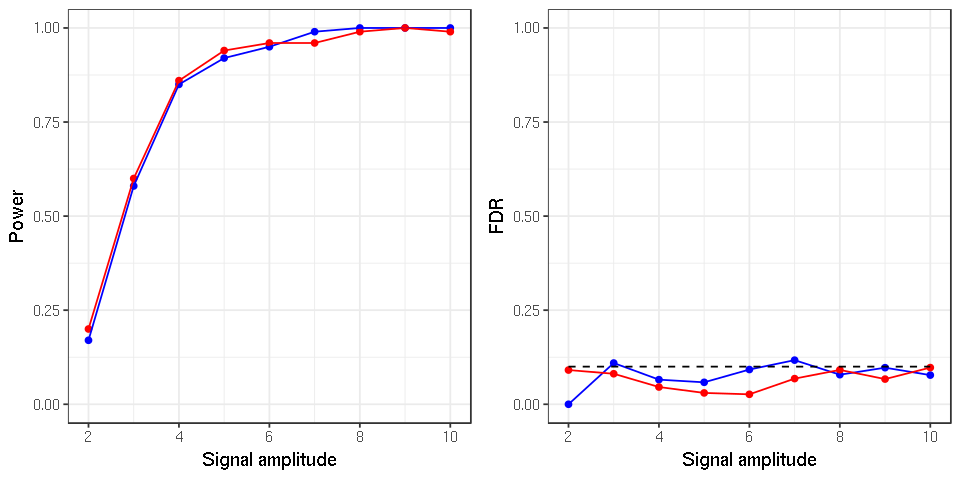

In [7]:
# LMM with oracle FDR control
Summary.LMM.oracle <- Results.lmm.tmp %>% group_by(Method, Amplitude) %>%
    summarise(Power.sd = 2*sd(Power)/sqrt(n()), Power=mean(Power),
              FDR.sd=2*sd(FDP)/sqrt(n()), FDR=mean(FDP), 
              Size=mean(Size,na.rm=TRUE), BP.width=mean(BP.width,na.rm=TRUE)) %>%
    ungroup() %>%
    group_by(Amplitude) %>%
    filter(FDR<=0.1) %>%
    summarise(Oracle = which.max(Power),
              Power.sd = Power.sd[Oracle], Power=Power[Oracle],
              FDR.sd=FDR.sd[Oracle], FDR=FDR[Oracle],
              Size=Size[Oracle], BP.width=BP.width[Oracle]) %>%
    mutate(Method="LMM_oracle") %>%
    select(Method, Amplitude, FDR, FDR.sd, Power, Power.sd, Size, BP.width)

Summary.knockoffs <- Results %>% 
    filter(Method %in% c("Knockoffs_Radj2")) %>%
    group_by(Method.type, Method, Amplitude) %>%
    summarise(Power.sd=2*sd(Power)/sqrt(n()), Power=mean(Power), 
              FDR.sd=2*sd(FDP)/sqrt(n()), Power=mean(Power), FDR=mean(FDP),
              Size=mean(Size,na.rm=TRUE), BP.width=mean(BP.width,na.rm=TRUE)) %>%
    ungroup() %>%
    select(Method, Amplitude, 
           FDR, FDR.sd, Power, Power.sd, Size, BP.width)

FDR.dummy <- tibble(Amplitude=unique(Summary.knockoffs$Amplitude), FDR=0.1)

p.pow <- rbind(Summary.knockoffs, Summary.LMM.oracle) %>% as_tibble() %>%
    ggplot(aes(x=Amplitude, y=Power, color=Method)) +
    geom_point() + geom_line() +
    geom_errorbar(width=.1, aes(ymin=Power-Power.sd, 
                                ymax=Power+Power.sd)) +
    scale_colour_manual(values = c("blue", "red")) +
    ylim(0,1) +
    xlab("Signal amplitude") + ylab("Power") +
    theme_bw() + theme(legend.position="none")

p.fdp <- rbind(Summary.knockoffs, Summary.LMM.oracle) %>% as_tibble() %>%
    ggplot(aes(x=Amplitude, y=FDR, color=Method)) +
    geom_point() + geom_line() +
    geom_errorbar(width=.1, aes(ymin=FDR-FDR.sd, ymax=FDR+FDR.sd)) +
    geom_line(data=FDR.dummy, aes(color="red"), color="black", linetype="dashed") +
    scale_colour_manual(values = c("blue", "red")) +
    ylim(0,1) +
    xlab("Signal amplitude") + ylab("FDR") +
    theme_bw() + theme(legend.position="none")

pp <- grid.arrange(p.pow, p.fdp, nrow = 1)
p.file <- sprintf("figures/locus_oracle.png")
ggsave(p.file, pp, width=8, height=4)

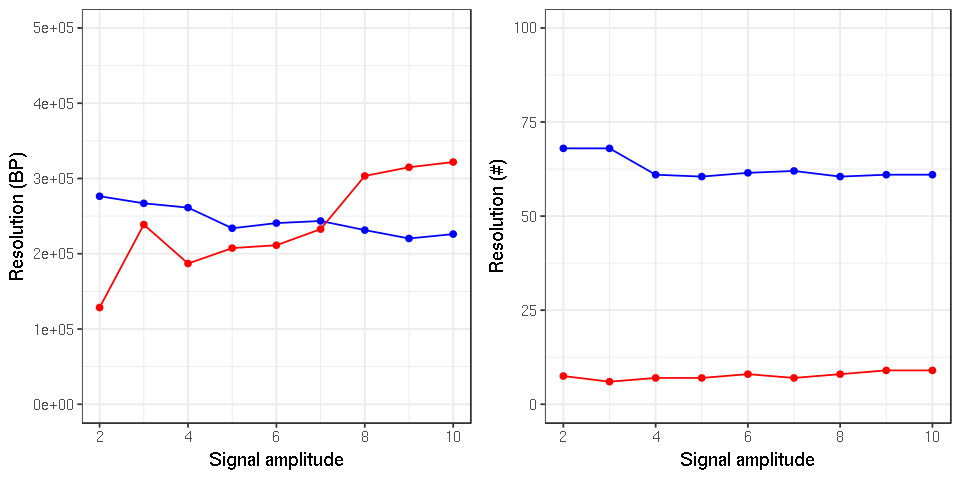

In [8]:
p.BP <- rbind(Summary.knockoffs, Summary.LMM.oracle) %>% as_tibble() %>%
    ggplot(aes(x=Amplitude, y=BP.width, group=Method, color=Method,  alpha=Method)) +
    geom_point() + geom_line() +
    scale_colour_manual(values = c("blue", "red")) +
    scale_alpha_manual(values = c(1, 1)) +
    xlab("Signal amplitude") + ylab("Resolution (BP)") +
    ylim(0,500000) +
    theme_bw() + theme(legend.position="none")

p.N <- rbind(Summary.knockoffs, Summary.LMM.oracle) %>% as_tibble() %>%
    ggplot(aes(x=Amplitude, y=Size, group=Method, color=Method, alpha=Method)) +
    geom_point() + geom_line() +
    scale_colour_manual(values = c("blue", "red")) +
    scale_alpha_manual(values = c(1, 1)) +
    xlab("Signal amplitude") + ylab("Resolution (#)") +
    ylim(0,100) +
    theme_bw() + theme(legend.position="none")

pp <- grid.arrange(p.BP, p.N, nrow = 1)
p.file <- "figures/locus_resolution_oracle.png"
ggsave(p.file, pp, width=8, height=4)